This notebook puts together all the code needed to add the evaluation metrics, and exports all results to a zip file.

Zip all the results into a zip file.

In [2]:
import shutil
output_filename = 'training_w2vec'
dir_name = output_filename
shutil.make_archive(output_filename, 'zip', dir_name)

'/root/training_w2vec.zip'

In [3]:
import boto3

s3 = boto3.resource('s3')
BUCKET = "wherewillway"

s3.Bucket(BUCKET).upload_file(f"{output_filename}.zip", f"{output_filename}.zip")

In [10]:
directories = path.Path('./training_w2vec/').dirs()

### Assembling the predictions

In [62]:
import pandas as pd
slices_lr = []
slices_lgbm = []
slices_rf = []
slices_et = []
for i in sorted(directories):
    if 'ipynb_checkpoints' not in i:
        category = i.split('/')[-1].split('_')[-1]
        data = pd.read_csv(i / f'predictions_{category}.csv')
        slices_lr.append(data['prediciton_label_lr'])
        slices_lgbm.append(data['prediciton_label_lgbm'])
        slices_rf.append(data['prediciton_label_rf'])
        slices_et.append(data['prediciton_label_et'])

In [65]:
prediction_lr = pd.concat(slices_lr,axis=1).to_numpy()
prediction_lgbm = pd.concat(slices_lgbm,axis=1).to_numpy()
prediction_rf = pd.concat(slices_rf,axis=1).to_numpy()
prediction_et = pd.concat(slices_et,axis=1).to_numpy()

In [71]:
data_ = pd.read_csv(path.Path('.') / 'training_batch_800_809.csv')

In [76]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_, random_state=42, test_size=0.30, shuffle=True)

In [80]:
test_truth = test.iloc[:,-15:].to_numpy()

In [82]:
!pip install Levenshtein -q

Keyring is skipped due to an exception: 'keyring.backends'


In [85]:
!pip install jaro-winkler -q

Keyring is skipped due to an exception: 'keyring.backends'


In [92]:
from sklearn.metrics import hamming_loss, jaccard_score, classification_report, multilabel_confusion_matrix, f1_score, accuracy_score, log_loss
from Levenshtein import distance as levenshtein_distance
import jaro
import numpy as np
def eval_test_report(true_bools,pred_bools, model_name):
    '''
    true_label: numpy array consisting of list (length 15 = num_labels) of actual labels [1,0,1,...,0]
    true_label: numpy array consisting of list (length 15 = num_labels) of predicted labels [1,0,1,...,0]
    '''
    
    report_dict = {}
    report_dict['jaccard'] = 100.0*jaccard_score(true_bools,pred_bools, average="macro")
    report_dict['f1_score_micro'] = 100.0*f1_score(true_bools, pred_bools,average='micro')
    report_dict['f1_score_macro'] = 100.0*f1_score(true_bools, pred_bools,average='macro')
    report_dict['accuracy_score'] = 100.0*accuracy_score(true_bools, pred_bools)
    
    # lower the better
    report_dict['hamming_loss'] = hamming_loss(true_bools, pred_bools)
    report_dict['log_loss'] = log_loss(true_bools,pred_bools)
    
    # similarity by string matching
    pred_str = [''.join(list(map(str, (list(x))))) for x in list(pred_bools)]
    true_str = [''.join(list(map(str, (list(x))))) for x in list(true_bools)]



    sim = []
    i = 0
    while i < len(pred_str):
        sim.append(jaro.jaro_winkler_metric(true_str[i],pred_str[i]))
        i+=1
    
    report_dict['jaro_mean'] = 100.0*np.mean(sim)
    
    sim = []
    i = 0
    while i < len(pred_str):
        sim.append(levenshtein_distance(true_str[i],pred_str[i]))
        i+=1
    
    report_dict['lev_mean'] = np.mean(sim)
    
#     print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories)
    final = {model_name: report_dict}
    
    return pd.DataFrame(final)

### Reporting evaluation metrics for Logistic Regression

In [101]:
eval_test_report(test_truth, prediction_lr, model_name='pretrained_w2vec_Logistic_Regression')

,pretrained_w2vec_Logistic_Regression
accuracy_score,13.646394
f1_score_macro,68.871114
f1_score_micro,83.274441
hamming_loss,0.127239
jaccard,56.762089
jaro_mean,92.181450
lev_mean,1.875104
log_loss,48.382947


### Reporting evaluation metrics for LGBM

In [102]:
eval_test_report(test_truth, prediction_lgbm, model_name='pretrained_w2vec_LGBM')

,pretrained_w2vec_LGBM
accuracy_score,13.987429
f1_score_macro,69.952615
f1_score_micro,83.417688
hamming_loss,0.126704
jaccard,57.587022
jaro_mean,92.248911
lev_mean,1.865542
log_loss,47.437073


### Reporting evaluation metrics for Random Forest

In [103]:
eval_test_report(test_truth, prediction_rf, model_name='pretrained_w2vec_Random_Forest')

,pretrained_w2vec_Random_Forest
accuracy_score,12.788793
f1_score_macro,65.146695
f1_score_micro,82.659774
hamming_loss,0.131733
jaccard,53.645234
jaro_mean,92.010469
lev_mean,1.937243
log_loss,49.801272


### Reporting evaluation metrics for Extra Tree Classifier

In [104]:
eval_test_report(test_truth, prediction_et, model_name='pretrained_w2vec_Extra_Tree')

,pretrained_w2vec_Extra_Tree
accuracy_score,12.653382
f1_score_macro,64.084770
f1_score_micro,82.482826
hamming_loss,0.132943
jaccard,52.813942
jaro_mean,91.994049
lev_mean,1.953308
log_loss,50.301319


### Classification Report for Logistic Regression

In [111]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, prediction_lr, target_names=list(data_.columns[-15:])))

              precision    recall  f1-score   support

           A       0.79      0.72      0.75     24695
           B       0.97      0.98      0.98     55032
           C       0.88      0.86      0.87     32271
           D       0.91      0.88      0.90     35756
           E       0.83      0.94      0.88     46510
           F       0.83      0.68      0.75     12483
           G       0.83      0.88      0.85     40604
           H       0.60      0.10      0.18      7755
           I       0.71      0.50      0.58      7977
           J       0.74      0.42      0.54      8465
           K       0.73      0.18      0.28      1756
           L       0.71      0.34      0.46      9856
           M       0.85      0.85      0.85     24418
           N       0.81      0.82      0.81     31817
           Z       0.76      0.56      0.64     11152

   micro avg       0.86      0.81      0.83    350547
   macro avg       0.80      0.65      0.69    350547
weighted avg       0.85   

### Classification Report for LGBM

In [113]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, prediction_lgbm, target_names=list(data_.columns[-15:])))

              precision    recall  f1-score   support

           A       0.79      0.73      0.76     24695
           B       0.97      0.98      0.98     55032
           C       0.87      0.87      0.87     32271
           D       0.91      0.88      0.89     35756
           E       0.83      0.94      0.88     46510
           F       0.83      0.67      0.74     12483
           G       0.83      0.88      0.86     40604
           H       0.60      0.14      0.23      7755
           I       0.70      0.52      0.60      7977
           J       0.76      0.44      0.55      8465
           K       0.70      0.22      0.33      1756
           L       0.73      0.36      0.48      9856
           M       0.84      0.87      0.85     24418
           N       0.81      0.82      0.82     31817
           Z       0.75      0.57      0.65     11152

   micro avg       0.85      0.82      0.83    350547
   macro avg       0.79      0.66      0.70    350547
weighted avg       0.84   

### Classification Report for Random Forst

In [117]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, prediction_rf, target_names=list(data_.columns[-15:])))

              precision    recall  f1-score   support

           A       0.80      0.70      0.75     24695
           B       0.96      0.99      0.98     55032
           C       0.86      0.87      0.87     32271
           D       0.90      0.88      0.89     35756
           E       0.82      0.96      0.88     46510
           F       0.85      0.59      0.70     12483
           G       0.82      0.89      0.85     40604
           H       0.66      0.07      0.13      7755
           I       0.73      0.42      0.53      7977
           J       0.81      0.32      0.46      8465
           K       0.87      0.05      0.09      1756
           L       0.80      0.25      0.38      9856
           M       0.82      0.87      0.84     24418
           N       0.80      0.83      0.81     31817
           Z       0.79      0.49      0.60     11152

   micro avg       0.85      0.80      0.83    350547
   macro avg       0.82      0.61      0.65    350547
weighted avg       0.84   

### Classification Report for Extra Tree Classifier

In [118]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, prediction_et, target_names=list(data_.columns[-15:])))

              precision    recall  f1-score   support

           A       0.80      0.69      0.74     24695
           B       0.96      0.99      0.98     55032
           C       0.85      0.88      0.87     32271
           D       0.90      0.88      0.89     35756
           E       0.81      0.97      0.88     46510
           F       0.85      0.58      0.69     12483
           G       0.82      0.89      0.85     40604
           H       0.65      0.05      0.10      7755
           I       0.73      0.40      0.52      7977
           J       0.82      0.29      0.43      8465
           K       0.94      0.03      0.07      1756
           L       0.83      0.23      0.36      9856
           M       0.82      0.86      0.84     24418
           N       0.80      0.83      0.81     31817
           Z       0.79      0.46      0.59     11152

   micro avg       0.85      0.80      0.82    350547
   macro avg       0.83      0.60      0.64    350547
weighted avg       0.84   

### Blend Model Result
Blend model is a voting classifier that is trained with the above 4 classifiers.

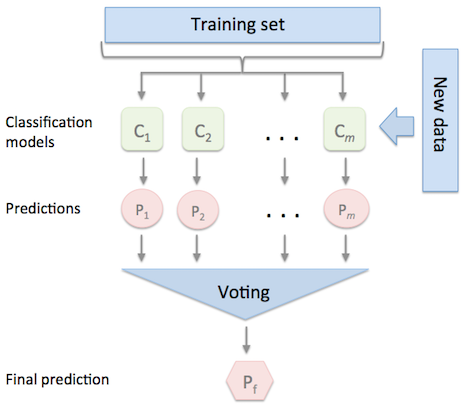

### Evaluating the results

In [121]:
import pandas as pd
slices_blend = []
for i in sorted(directories):
    if 'ipynb_checkpoints' not in i:
        category = i.split('/')[-1].split('_')[-1]
        data = pd.read_csv(i / f'blend_predicitons_{category}.csv')
        slices_blend.append(data['prediction_label'])

In [124]:
blend_preds = pd.concat(slices_blend,axis=1).to_numpy()

In [125]:
eval_test_report(test_truth, blend_preds, model_name='pretrained_w2vec_Ensembled')

,pretrained_w2vec_Ensembled
accuracy_score,14.084389
f1_score_macro,68.015017
f1_score_micro,83.494106
hamming_loss,0.125729
jaccard,56.194564
jaro_mean,92.271024
lev_mean,1.852770
log_loss,47.762273


In [126]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, blend_preds, target_names=list(data_.columns[-15:])))

              precision    recall  f1-score   support

           A       0.80      0.72      0.76     24695
           B       0.97      0.99      0.98     55032
           C       0.87      0.87      0.87     32271
           D       0.91      0.88      0.90     35756
           E       0.82      0.96      0.89     46510
           F       0.85      0.65      0.74     12483
           G       0.83      0.89      0.86     40604
           H       0.66      0.09      0.16      7755
           I       0.72      0.48      0.58      7977
           J       0.79      0.38      0.51      8465
           K       0.88      0.13      0.22      1756
           L       0.78      0.30      0.44      9856
           M       0.84      0.87      0.85     24418
           N       0.81      0.83      0.82     31817
           Z       0.78      0.54      0.64     11152

   micro avg       0.86      0.81      0.83    350547
   macro avg       0.82      0.64      0.68    350547
weighted avg       0.85   

### Conclusion 

From the above results we can see that the `accuracy` and `jaccard score` is pretty low, but forms the baseline of our classification task.  